In [189]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import measures as ms
from states import make_state
from networkviz import draw_MI

initial norm of state: 44.828572994195405
final norm of state: 1.0


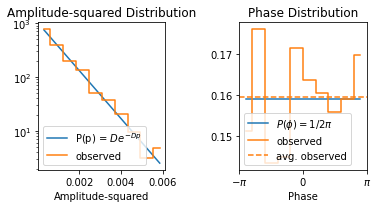

In [151]:
L = 10    # number of qubits
D = 2**L  # Hilbert space dimension

# Using Gussian-distributed real and imaginary parts for each amplitude
# make random L-qubit state.
stateR = np.random.normal(0, 1, 2**L)
stateI = np.random.normal(0, 1, 2**L)
state= stateR + 1j*stateI

# normalize state
nrm = np.sqrt(np.conj(state).dot(state)).real
state /= nrm
print("initial norm of state:", nrm)
print("final norm of state:", np.sqrt(np.conj(state).dot(state)).real)

# plotting to verify expected distributions
fig, axs = plt.subplots(1,2, figsize=(5.3, 3.))
ps = (np.conj(state)*state).real # probabilities should follow porter thomas
phis = np.angle(state) # phases should be flat

# amplitude distribution plot
hista, bina = np.histogram(ps, bins=10, density=True)
bina = (bina[1:]+bina[:-1])/2
axs[0].plot(bina, D*np.exp(-D*bina), label="P(p) = $D e^{-D p}$")
axs[0].step(bina, hista, where="mid", label="observed")
axs[0].legend(loc="lower left")
axs[0].set_title("Amplitude-squared Distribution")
axs[0].set_xlabel("Amplitude-squared")
axs[0].set_yscale("log")

# phase distribution plot
histp, binp = np.histogram(phis, bins=10, density=True)
binp = (binp[1:]+binp[:-1])/2
axs[1].plot(binp, np.ones_like(binp)/(2*np.pi), label="$P(\phi)=1/2\pi$")
axs[1].step(binp, histp, where="mid", label="observed")
axs[1].axhline(np.mean(histp), ls="--", c="C1", label="avg. observed")
axs[1].legend(loc="lower left")
axs[1].set_title("Phase Distribution");
axs[1].set_xlabel("Phase")
axs[1].set_xticks([-np.pi, 0, np.pi])
axs[1].set_xticklabels(["$-\pi$","0","$\pi$"])
fig.tight_layout()
plt.savefig(f"figures/Porter_Thomas-L{L}_statistics.pdf")

In [4]:
# fit a power law to x,y data
# m gives the exponent, b gives the scale, 
# func(x) gives the best fit (unweighted reduced chi-squared)
def power_law_fit(x, y):
    m, b = np.polyfit(np.log10(x), np.log10(y), deg=1)
    def func(x):
        return 10**b * x**m
    return m, b, func

In [5]:
# fit an exponential to x,y data
# m gives the exponent, b fives the scale, 
# func(x) gives the best fit (unweighted reduced chi-squared)
def exponential_fit(x, y):
    m, b = np.polyfit(x, np.log(y), deg=1)
    def func(x):
        return np.exp(b + m*x)
    return m, b, func

In [141]:
sbisects = []
netCs = []
netDs = []
netYs = []
Ls = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
for L in Ls:
    N = int(2**16/2**L)
    rhoj = 0+0j
    rhojk = 0+0j
    bisect = 0+0j
    N = 100
    for i in range(N):
        # same process above is available in the states.py library
        state = make_state(L, "P")
    
        # compute density matricies
        rhoj += ms.get_rhoj(state) / N
        rhojk += ms.get_rhojk(state) / N
        bisect += ms.get_bisect(state) / N

   
    # compute intermediate measures
    s1 = ms.get_entropy(rhoj, order=1)
    s2 = ms.get_entropy2(rhojk, order=1)
    M = ms.get_MI(s1, s2)
    
    # compute measures and append to lists
    sbisects.append(ms.renyi_entropy(bisect, order=2))
    netCs.append(ms.network_clustering(M))
    netDs.append(ms.network_density(M))
    netYs.append(ms.network_disparity(M))
        

# lists to numpy arrays
sbisect = np.array(sbisects)
netCs = np.array(netCs)
netDs =np.array(netDs)
netYs = np.array(netYs)

In [142]:
# fit system size scaling
Ls = np.array(Ls)
mS, bS, funcS = power_law_fit(Ls, sbisects)
mC, bC, funcC = exponential_fit(Ls, netCs)
mD, bD, funcD = exponential_fit(Ls, netDs)
mY, bY, funcY = power_law_fit(Ls, netYs)

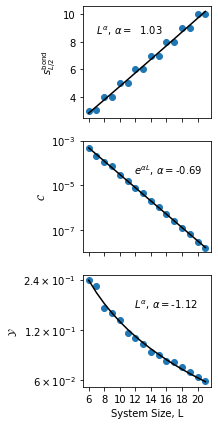

In [165]:
# Plot system size scaling
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(2.3,7))
axs[0].plot(Ls, sbisects, marker="o", ls="none")
axs[0].plot(Ls, funcS(Ls), c="k")
axs[0].text(0.1, 0.75, 
            r"$L^{\alpha},\,\alpha=$  %s"%round(mS,2), transform=axs[0].transAxes)
axs[0].set_ylabel(r"$s^{\rm bond}_{L/2}$")
#axs[0].set_yscale("log")

axs[1].plot(Ls, netCs, marker="o", ls="none")
axs[1].plot(Ls, funcC(Ls), c="k")
axs[1].text(0.4, 0.7, 
            r"$e^{\alpha L},\,\alpha=$%s"%round(mC,2), transform=axs[1].transAxes)

axs[1].set_ylabel(r"$\mathcal{C}$")
axs[1].set_yscale("log")
axs[1].set_yticks([1e-7, 1e-5, 1e-3])

#axs[2].plot(Ls, netDs, marker="o", ls="none")
#axs[2].plot(Ls, funcD(Ls), c="k")
#axs[2].text(0.4, 0.7, 
#             r"$e^{\alpha L},\,\alpha=$%s"%round(mD,2), transform=axs[2].transAxes)
#axs[2].set_ylabel(r"$\mathcal{D}$")
#axs[2].set_yscale("log")

axs[2].plot(Ls, netYs, marker="o", ls="none")
axs[2].plot(Ls, funcY(Ls), c="k")
axs[2].text(0.4, 0.7, 
             r"$L^{\alpha},\,\alpha=$%s"%round(mY,2), transform=axs[2].transAxes)
axs[2].set_ylabel(r"$\mathcal{Y}$")
#axs[3].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("System Size, L")
axs[2].set_xticks(Ls[::2])
axs[2].set_xticklabels(Ls[::2])
axs[2].set_yticks([0.06, 0.12, 0.24])
axs[2].minorticks_off()

plt.savefig(f"figures/Porter_Thomas-Lscaling.pdf", bbox_inches="tight")

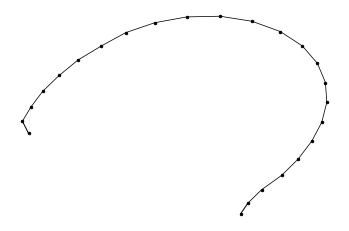

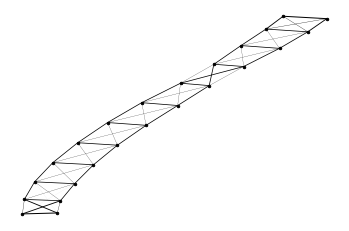

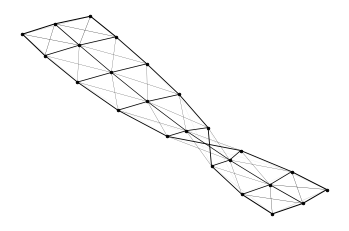

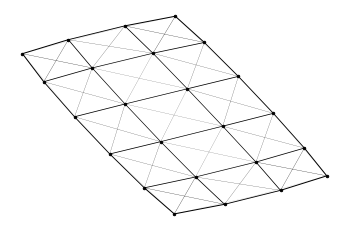

In [232]:
sbisects = []
netCs = []
netDs = []
netYs = []
Ls = np.array([24, 24, 24, 24])
state_strs = ["C1-24", "C2-12", "C3-8", "C4-6"]
for ss,L in zip(state_strs, Ls):
    # same process above is available in the states.py library
    state = make_state(L, ss)
    
    # compute density matricies
    rhoj = ms.get_rhoj(state)
    rhojk = ms.get_rhojk(state)
    bisect = ms.get_bisect(state)

   
    # compute intermediate measures
    s1 = ms.get_entropy(rhoj, order=1)
    s2 = ms.get_entropy2(rhojk, order=1)
    M = ms.get_MI(s1, s2)
    
    fig, axi = plt.subplots(1,1)
    draw_MI(M, axi, layout="spring")
    plt.show()
    
    # compute measures and append to lists
    sbisects.append(ms.renyi_entropy(bisect, order=2))
    netCs.append(ms.network_clustering(M))
    netDs.append(ms.network_density(M))
    netYs.append(ms.network_disparity(M))
        

# lists to numpy arrays
sbisect = np.array(sbisects)
netCs = np.array(netCs)
netDs =np.array(netDs)
netYs = np.array(netYs)

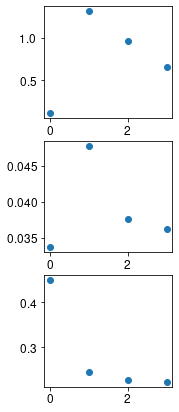

In [240]:
# Plot system size scaling
fig, axs = plt.subplots(3, 1, figsize=(2.3,7))
axs[0].plot(sbisects, marker="o", ls="none")
axs[1].plot(netCs, marker="o", ls="none")
axs[2].plot(netYs, marker="o", ls="none")
